In [1]:
import json
import os
import glob

import matplotlib.pyplot as plt
from pdf2image import convert_from_path
import numpy as np
import cv2 as cv
from operator import itemgetter

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
SCITSR_PATH = '/Users/longhoang/Developer/table-reg/data/SciTSR'
# NOTE: change the path to your dataset above 👆

SCITSR_TRAIN = os.path.join(SCITSR_PATH, 'train')
SCITSR_TEST = os.path.join(SCITSR_PATH, 'test')

In [3]:
def get_files(folders, ext):
    total_files = []
    for folder in folders:
        files = glob.glob(folder + '/*.' + ext)
        files.sort()
        total_files.extend(files)
    return total_files

In [4]:
SCITSR_TRAIN_IMG = os.path.join(SCITSR_TRAIN, 'img')
imgs_paths = get_files([SCITSR_TRAIN_IMG], 'png')
len(imgs_paths)

12000

In [5]:
def load_img(img_path):
    img = cv.imread(img_path)
    if img is None:
        print(f"* Error: Unable to read image from {img_path}")
        return None
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

def view_imgs(imgs):
    fig = plt.figure(figsize=(7,7))
    for i, img in enumerate(imgs):
        plt.subplot(1, len(imgs), i+1)
        if img.ndim == 3:
            if img.shape[-1] == 3:
                plt.imshow(img)
            else:
                plt.imshow(img[..., 0], cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()

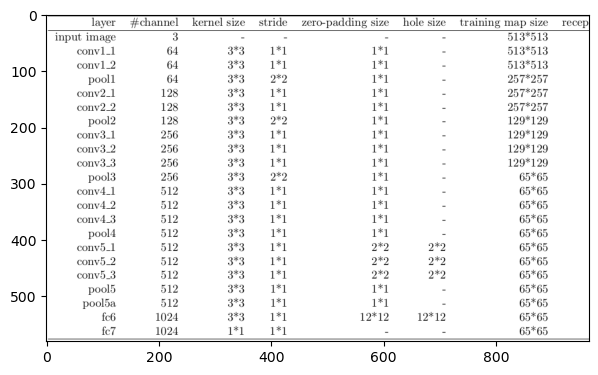

Shape: (581, 966, 3)


In [6]:
# img_path = imgs_paths[15]
img_path = '/Users/longhoang/Developer/table-reg/data/SciTSR/train/img/1601.04798v3.1.png'
img = load_img(img_path)
view_imgs([img])
print(f'Shape: {img.shape}')

In [7]:
def get_table_pos(pdf_path, display=False):
    imgs_pdf = convert_from_path(pdf_path, 150)
    assert len(imgs_pdf) == 1, 'There is more than one pdf image'
    img_pdf = np.array(imgs_pdf[0])
    gray = cv.cvtColor(img_pdf, cv.COLOR_RGB2GRAY)
    thresh, gray = cv.threshold(gray, 200, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
    coords = cv.findNonZero(gray)
    x, y, w, h = cv.boundingRect(coords)
    left, top, right, bottom = x - 3, y - 3, x + w + 3, y + h + 3
    if display:
        top_left = (round(left), round(top))
        bottom_right = (round(right), round(bottom))
        cv.rectangle(img_pdf, top_left, bottom_right, (0, 0, 255), 3)
        view_imgs([img_pdf])
        print('Shape: ' + str(img_pdf.shape))
    return left, top, right, bottom

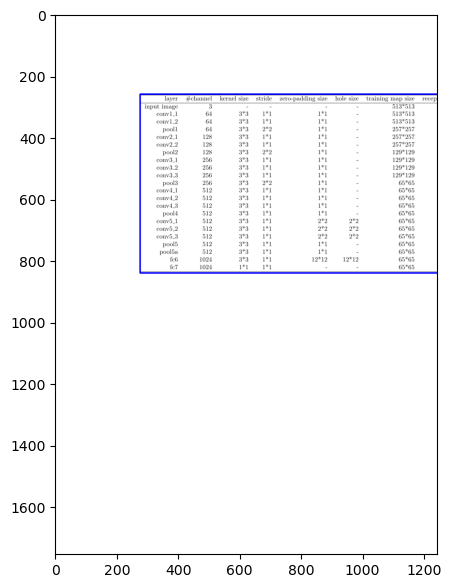

Shape: (1754, 1241, 3)
Top left: (257, 276)
Bottom right: (839, 1244)


In [8]:
img_pdf_path = img_path.replace('png', 'pdf').replace('img', 'pdf')

left, top, right, bottom = get_table_pos(img_pdf_path, True)
print(f'Top left: ({top}, {left})')
print(f'Bottom right: ({bottom}, {right})')

In [9]:
def coord_pdf2img(x, y, left, top):
    ratio = 1754 / 842
    new_x = x * ratio - left
    new_y = 1754 - y * ratio - top
    return new_x, new_y

def read_chunk(chunk_path, left, top, display=False):
    Chunks = []
    with open(chunk_path) as f:
      data = json.load(f)
      chunks = data['chunks']
      #print(len(chunks))
      for c in chunks:
          pos = c['pos']
          l,r,t,b = int(pos[0]), int(pos[1]), int(pos[2]), int(pos[3])
          if display: print('OG       :', l,t,r,b, '--', c['text'])
          l,t = coord_pdf2img(l,t, left, top)
          r,b = coord_pdf2img(r,b, left, top)
          if display: print('Converted:', int(l), int(t), int(r), int(b))
          if t > b: t, b = b, t
          Chunks.append((c['text'], [int(l), int(t)-5, int(r), int(b)]))
    return Chunks

In [10]:
img_chunk_path = img_path.replace('png', 'chunk').replace('img', 'chunk')

chunks = read_chunk(img_chunk_path, left, top, True)

OG       : 170 708 191 713 -- layer
Converted: 78 22 121 11
OG       : 203 708 244 713 -- #channel
Converted: 146 22 232 11
OG       : 256 708 301 713 -- kernel size
Converted: 257 22 351 11
OG       : 313 708 338 713 -- stride
Converted: 376 22 428 11
OG       : 350 708 424 713 -- zero-padding size
Converted: 453 22 607 11
OG       : 436 708 473 713 -- hole size
Converted: 632 22 709 11
OG       : 485 708 560 713 -- training map size
Converted: 734 22 890 11
OG       : 572 708 652 713 -- receptive ﬁeld size
Converted: 915 22 1082 11
OG       : 663 708 700 713 -- #weight
Converted: 1105 22 1182 11
OG       : 139 695 191 700 -- input image
Converted: 13 49 121 38
OG       : 239 695 244 700 -- 3
Converted: 221 49 232 38
OG       : 298 695 301 700 -- -
Converted: 344 49 351 38
OG       : 334 695 338 700 -- -
Converted: 419 49 428 38
OG       : 421 695 424 700 -- -
Converted: 601 49 607 38
OG       : 470 695 473 700 -- -
Converted: 703 49 709 38
OG       : 525 695 560 700 -- 513*513
Conver

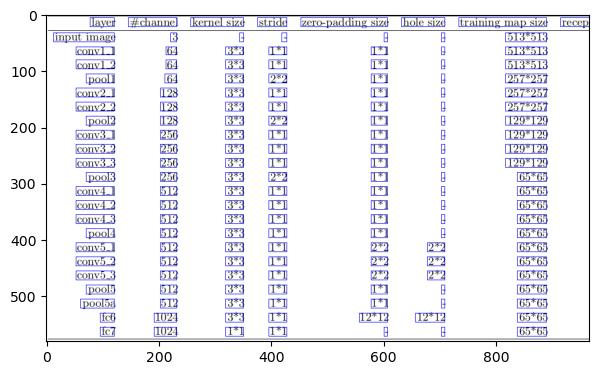

In [11]:
img_draw = img.copy()

for chunk in chunks:
    pos = chunk[1]
    left_top = (pos[0], pos[1])
    bottom_right = (pos[2], pos[3])
    cv.rectangle(img_draw, left_top, bottom_right, (0, 0, 255), 1)

view_imgs([img_draw])

In [12]:
def read_cells(struct_path):  # đọc file structure trả về số lượng dòng số lượng cột và các cột có merge nhau hay ko
    Cells = []
    nRow, nCol = 0, 0
    with open(struct_path) as f:
        data = json.load(f)
        cells = data['cells']
        for c in cells:
            content = c['content']
            if content is None: continue
            id = c['id']
            sr, er = c['start_row'], c['end_row']
            sc, ec = c['start_col'], c['end_col']
            nRow = max(nRow, er+1)
            nCol = max(nCol, ec+1)
            Cells.append({'id': id, 'range': [sr, er, sc, ec], 'content': content})

    Cells = sorted(Cells, key=itemgetter('id'))

    return nRow, nCol, Cells

In [13]:
img_struct_path = img_path.replace('png', 'json').replace('img', 'structure')

n_rows, n_cols, cells = read_cells(img_struct_path)

In [16]:
cells

[{'id': 0, 'range': [0, 0, 0, 0], 'content': ['layer']},
 {'id': 1, 'range': [0, 0, 1, 1], 'content': ['#channel']},
 {'id': 2, 'range': [0, 0, 2, 2], 'content': ['kernel', 'size']},
 {'id': 3, 'range': [0, 0, 3, 3], 'content': ['stride']},
 {'id': 4, 'range': [0, 0, 4, 4], 'content': ['zero-padding', 'size']},
 {'id': 5, 'range': [0, 0, 5, 5], 'content': ['hole', 'size']},
 {'id': 6, 'range': [0, 0, 6, 6], 'content': ['training', 'map', 'size']},
 {'id': 7, 'range': [0, 0, 7, 7], 'content': ['receptive', 'ﬁeld', 'size']},
 {'id': 8, 'range': [0, 0, 8, 8], 'content': ['#weight']},
 {'id': 9, 'range': [1, 1, 0, 0], 'content': ['input', 'image']},
 {'id': 10, 'range': [1, 1, 1, 1], 'content': ['3']},
 {'id': 11, 'range': [1, 1, 2, 2], 'content': ['-']},
 {'id': 12, 'range': [1, 1, 3, 3], 'content': ['-']},
 {'id': 13, 'range': [1, 1, 4, 4], 'content': ['-']},
 {'id': 14, 'range': [1, 1, 5, 5], 'content': ['-']},
 {'id': 15, 'range': [1, 1, 6, 6], 'content': ['513*513']},
 {'id': 16, 'ran

In [17]:
def update_cells(cells, chunks):
    ChunkSkip = 0
    for i, c in enumerate(cells):
        if c['content'] == [] or i - ChunkSkip >= len(chunks):
            cells[i].update({'pos': [0,0,0,0]})
            ChunkSkip += 1
        else:
            cells[i].update({'pos': chunks[i-ChunkSkip][1]})
        if c['range'][1] > c['range'][0]:
            cells[i].update({'flag': 1}) # flag 1 means rol-span cell
        elif c['range'][3] > c['range'][2]:
            cells[i].update({'flag': 2}) # flag 2 means col-span cell
        else:
            cells[i].update({'flag': 0}) # flag 0 means single cell
        #print(Cells)
        
    return cells       

In [18]:
cells_updt = update_cells(cells, chunks)
cells_updt

[{'id': 0,
  'range': [0, 0, 0, 0],
  'content': ['layer'],
  'pos': [78, 6, 121, 22],
  'flag': 0},
 {'id': 1,
  'range': [0, 0, 1, 1],
  'content': ['#channel'],
  'pos': [146, 6, 232, 22],
  'flag': 0},
 {'id': 2,
  'range': [0, 0, 2, 2],
  'content': ['kernel', 'size'],
  'pos': [257, 6, 351, 22],
  'flag': 0},
 {'id': 3,
  'range': [0, 0, 3, 3],
  'content': ['stride'],
  'pos': [376, 6, 428, 22],
  'flag': 0},
 {'id': 4,
  'range': [0, 0, 4, 4],
  'content': ['zero-padding', 'size'],
  'pos': [453, 6, 607, 22],
  'flag': 0},
 {'id': 5,
  'range': [0, 0, 5, 5],
  'content': ['hole', 'size'],
  'pos': [632, 6, 709, 22],
  'flag': 0},
 {'id': 6,
  'range': [0, 0, 6, 6],
  'content': ['training', 'map', 'size'],
  'pos': [734, 6, 890, 22],
  'flag': 0},
 {'id': 7,
  'range': [0, 0, 7, 7],
  'content': ['receptive', 'ﬁeld', 'size'],
  'pos': [915, 6, 1082, 22],
  'flag': 0},
 {'id': 8,
  'range': [0, 0, 8, 8],
  'content': ['#weight'],
  'pos': [1105, 6, 1182, 22],
  'flag': 0},
 {'id

In [19]:
def split_mask(img, cells):
    h, w, c = img.shape
    rMask = np.ones((h, w), np.uint8)
    cMask = np.ones((h, w), np.uint8)
    for c in cells:
        l, t, r, b = c['pos']
        if c['flag'] != 1:
            rMask[t:b, :] = 0
        if c['flag'] != 2:
            cMask[:, l:r] = 0
    return rMask, cMask

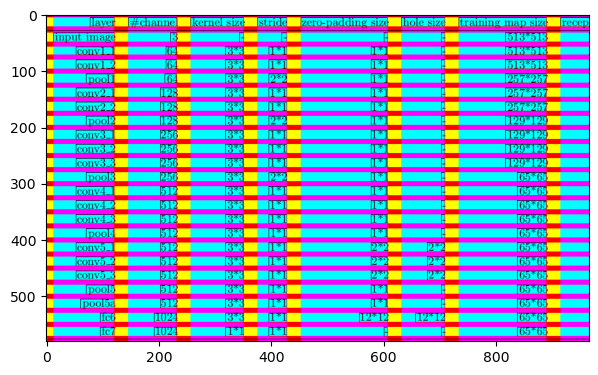

In [20]:
for c in cells_updt:
    lt, rb = (c['pos'][0], c['pos'][1]), (c['pos'][2], c['pos'][3])
    if c['flag'] == 1:
        cv.rectangle(img, lt, rb, (0,255,0), 1)
    elif c['flag'] == 2:
        cv.rectangle(img, lt, rb, (0,0,255), 1)
    else:
        cv.rectangle(img, lt, rb, (255,0,0), 1)
        
rMask, cMask = split_mask(img, cells)
MaskImg = np.stack([np.maximum(rMask, cMask)*255, 255-rMask*255, 255-cMask*255], axis=-1)
MaskImg = np.minimum(img, MaskImg)
view_imgs([MaskImg])

In [21]:
n_row_span_cells, n_col_span_cells = 0, 0

for c in cells_updt:
    if c['flag'] == 1: n_row_span_cells += 1
    elif c['flag'] == 2: n_col_span_cells += 1

n_row_span_cells, n_col_span_cells

(0, 0)

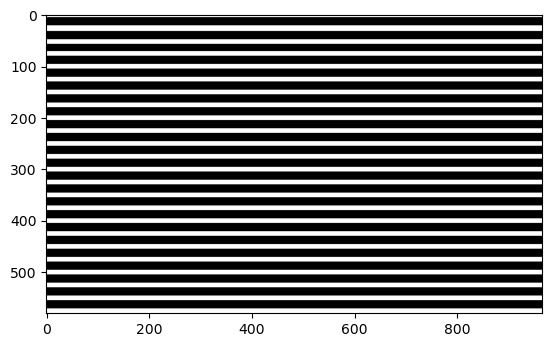

In [22]:
plt.imshow(rMask, cmap='gray')

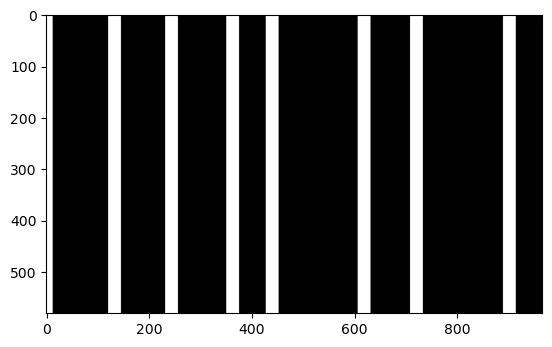

In [23]:
plt.imshow(cMask, cmap='gray')

In [21]:
cMask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [22]:
def process_mask(rMask, cMask):
    res = {
        'rows': rMask[:, 0].tolist(),
        'columns': cMask[0, :].tolist()
    }
    return res

In [23]:
res = process_mask(rMask, cMask)
res['rows'][:20], res['columns'][:20]

([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [24]:
# create label folder for Split & Merge module if it hasn't been created
LABEL_TRAIN = os.path.join(SCITSR_TRAIN, 'label')

if not os.path.exists(LABEL_TRAIN):
    os.makedirs(LABEL_TRAIN)

In [25]:
def img_name_from_path(img_path):
    img_name = img_path.split(os.sep)[-1]
    names = img_name.split('.')[:-1]
    return '.'.join(names)

In [26]:
img_name = img_name_from_path(img_path)
img_name

'1504.01777v2.6'

In [27]:
def write_json(json_path, data):
    with open(json_path, 'w') as f:
        json.dump(data, f)

Putting everything together

In [28]:
def prepare_label_split(folder_path: str, json_path: str):
    '''
    Params:
        folder_path -- string, path to either train or test folder
        json_path -- string, path to json file to write ground truth into
    Returns:
        None
    '''
    imgs_folder = os.path.join(folder_path, 'img') # access image folder
    imgs_paths = get_files([imgs_folder], 'png') # get list of image paths inside image folder

    LABELS = {} 
    for i, img_path in enumerate(imgs_paths):
        img = load_img(img_path) # load image as numpy array 
        if img is None: continue
        # view_imgs([img])
        
        # Get table position inside pdf file
        img_pdf_path = img_path.replace('png', 'pdf').replace('img', 'pdf')
        left, top, right, bottom = get_table_pos(img_pdf_path)
        
        # Read .chunk file to get coordinates of cells inside table
        # and convert from pdf coordinates to png coordinates
        img_chunk_path = img_path.replace('png', 'chunk').replace('img', 'chunk')
        chunks = read_chunk(img_chunk_path, left, top)
        
        # Read .json file from structure folder to know whether a cell is a span-cell or single
        img_struct_path = img_path.replace('png', 'json').replace('img', 'structure')
        n_rows, n_cols, cells = read_cells(img_struct_path)

        # update cells so that they have coordinates from chunks
        cells = update_cells(cells, chunks)

        # get row and columns mask (2D) and turn them each into 1D list 
        rMask, cMask = split_mask(img, cells)
        label = process_mask(rMask, cMask)

        # get image name and add to list of labels
        img_name = img_name_from_path(img_path)
        LABELS[img_name] = label
        if (i + 1) % 100 == 0: 
            print(f"Got labels for {i+1} images!")

    with open(json_path, 'w') as f:
        json.dump(LABELS, f)
    return None

In [30]:
LABEL_TRAIN_SPLIT = os.path.join(SCITSR_TRAIN, 'label', 'split_label.json')
# print(LABEL_TRAIN_SPLIT)

# prepare_label_split(SCITSR_TRAIN, LABEL_TRAIN_SPLIT)

In [ ]:
with open(LABEL_TRAIN_SPLIT, 'r') as f:
    data = json.load(f)

len(data)

11971

In [ ]:
test_label = data[img_name]
test_label['rows'] == res['rows'], test_label['columns'] == res['columns'], \
len(test_label['rows']) == img.shape[0], len(test_label['columns']) == img.shape[1]

(True, True, True, True)